## Jupyter Notebook to generate synthetic credit card application data.

### 1 row represents one application instance.

### The output dataset contains the following:

- app_ref - unique application reference number
- date - application data
- channel - channel through which the application was made
- product_type - which type of credit card the customer applied for 
- income - applicants income
- external_card - whether the applicant has a credit card with another company
- rev_debt - applicants existing revolving debt (credit card debt)
- unsec_debt - applicants total existing unsecured debt (includes revolving debt + any additional debt from unsecured loans)
- score - applicants application score 
- initial_accept - whether the application was initially accepted, referred or declined.
- final_accept - if initial_accept = refer, final_accept will be either accept or decline. Else final_accept = initial_accept
- take_up - flag for whether the customer has taken up our offer if their application was accepted
- booked - flag for whether we have booked the application
- offered_limit - the credit limit we offered the customer
- final_limit - the credit limit the customer took (can be offered_limit or below offered_limit)

### Import relevant modules

In [1]:
import datetime
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import skewnorm
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from faker import Faker # for generating fake dates
fake = Faker()

### Set number of rows for the output dataset

In [2]:
# set output dataset size

num_rows = 100000
num_rows_before_covid = int(num_rows*0.615)
num_rows_after_covid = int(num_rows*0.385)

In [5]:
# generate unique reference number for each application

# each row is assigned a sequential reference number

app_ref = []

for n in range(num_rows):
    app_ref.append(n+1)

### Produce 3 dataframes.

the before and after covid dataframes will be used for variables that show big differences in the
pre vs post covid period.

the full df will be the final output dataset, which is a union of the pre and post covid dataframes.

In [6]:
# df before covid
values = [app_ref[0:num_rows_before_covid]]
df_before_covid = pd.DataFrame(values).transpose()
df_before_covid.columns=['app_ref']
df_before_covid

# df after covid
values = [app_ref[num_rows_before_covid:num_rows]]
df_after_covid = pd.DataFrame(values).transpose()
df_after_covid.columns=['app_ref']
df_after_covid

# full df
frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)
df

,app_ref
0,1
1,2
2,3
3,4
4,5
...,...
99995,99996
99996,99997
99997,99998
99998,99999


### Create the fields to populate the dataframe

In [7]:
# Date

# generate fake dates for applications before and after covid
# the after covid period starts on 24/03/2020

date_before_covid = []

for n in range(num_rows_before_covid):
    date_before_covid.append(fake.date_between(start_date=datetime.date(year=2019,month=1,day=1), end_date=datetime.date(year=2020,month=3,day=23)))
    
date_after_covid = []

for n in range(num_rows_after_covid):
    date_after_covid.append(fake.date_between(start_date=datetime.date(year=2020,month=3,day=24), end_date='today'))
    
df_before_covid['date'] = date_before_covid
df_after_covid['date'] = date_after_covid

frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)

In [465]:
# Channel

# generate channel 

# before covid
np.random.seed(444)
channel_before_covid = np.random.choice(
    a=['internet_aggregator', 'internet_non_agg', 'branch', 'telephone', 'post'], # list of channels
    size=int(num_rows_before_covid), # number of values = num_rows_before_covid
    p=[0.55,0.22,0.2,0.005,0.025] # probabilities for each channel
)

# after covid
channel_after_covid = np.random.choice(
    a=['internet_aggregator', 'internet_non_agg', 'branch', 'telephone', 'post'],
    size=int(num_rows_after_covid), # number of values = num_rows_after_covid
    p=[0.545,0.445,0,0.01,0]
)

df_before_covid['channel'] = channel_before_covid
df_after_covid['channel'] = channel_after_covid

frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)

In [466]:
# Product type

# generate product type based on observed probabilities. Product type refers to the type of card applied for

# MA = matched
# BT = balance transfer
# RE = rewards card

np.random.seed(444)
product_type = np.random.choice(
    a=['MA','BT','RE'],
    size=num_rows,
    p=[0.485,0.265,0.25]
)

df['product_type'] = product_type

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

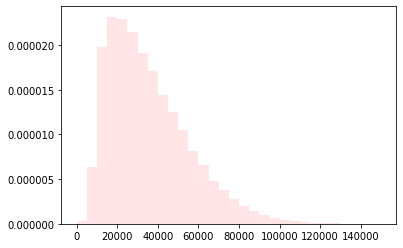

In [467]:
# Income

# generate random values for income that follow a right skewed distribution with a max value of 150,000 and standard deviation of 35111

# define paramaters to use with the skewnorm function
numValues = num_rows
maxValue = 150000
standard_deviation = 35111
skewness = 11   #Negative values are left skewed, positive values are right skewed.

# skewnorm.rvs generates random values according to a skewed normal distribution
income = skewnorm.rvs(a = skewness,loc=maxValue, scale=standard_deviation, size=numValues)  # skewnorm function + input parameters

income = income - min(income)      # shift the set so the minimum value is equal to zero.
income = income / max(income)      # standadize all the vlues between 0 and 1. 
income = income * maxValue        # multiply the standardized values by the maximum value.

# define rounddown function to return an integer value instead of a float
def rounddown(x):
    return int(math.floor(x / 1)) * 1

vrounddown = np.vectorize(rounddown) # vectorize the rounddown function so you can pass a numpy array in as its argument
income = vrounddown(income)

# plot histogram to check skewness
plt.hist(income,30,density=True, color = 'red', alpha=0.1)
plt.show()

df['income'] = income

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

In [468]:
# External card

np.random.seed(444)
external_card = np.random.choice(
    a=['Y','N'],
    size=num_rows,
    p=[0.69,0.31]
)

df['external_card'] = external_card

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

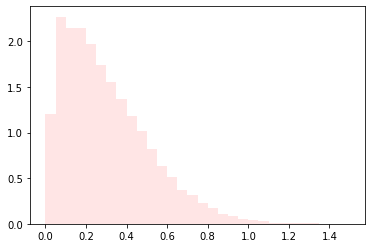

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [469]:
# Revolving debt to income (before covid)

# revolving debt tended to be higher before covid, with a right skewed distribution

numValues = df_before_covid['external_card'].value_counts()[0] # can only have revolving debt if you have an external card
maxValue = 1.5
skewness = 50   # negative values are left skewed, positive values are right skewed.

rev_dti = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  # skewnorm function

rev_dti = rev_dti - min(rev_dti)      # shift the set so the minimum value is equal to zero.
rev_dti = rev_dti / max(rev_dti)      # standadize all the vlues between 0 and 1. 
rev_dti = rev_dti * maxValue         # multiply the standardized values by the maximum value.

rev_dti = rev_dti.tolist() # need to change numpy array to list to use the pop function later on

# plot histogram to check skewness
plt.hist(rev_dti,30,density=True, color = 'red', alpha=0.1)
plt.show()

# function that takes in whether an applicant has an external card, and will apply one of the random rev_dti values
def apply_rev_dti(external_card, rev_dti_array):    
    if external_card == 'Y':
        i = np.random.randint(len(rev_dti_array), size=1)[0]
        selected = rev_dti_array.pop(i)
        return selected
    else:
        return 0

df_before_covid['rev_dti'] = df_before_covid['external_card'].apply(lambda x: apply_rev_dti(x,rev_dti))

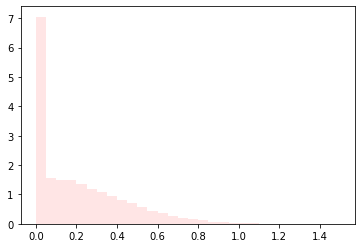

In [470]:
plt.hist(df_before_covid['rev_dti'],30,density=True, color = 'red', alpha=0.1)
plt.show()

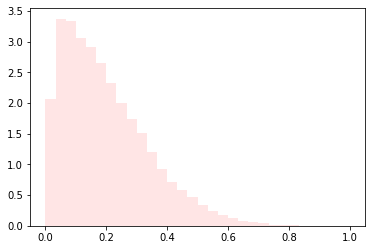

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [471]:
# Revolving debt to income (after covid)

# revolving debt after covid tended to reach a lower maxed value, but still with a right skewed distribution

numValues = df_after_covid['external_card'].value_counts()[0]
maxValue = 1.0
skewness = 50   #Negative values are left skewed, positive values are right skewed.

rev_dti = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

rev_dti = rev_dti - min(rev_dti)      #Shift the set so the minimum value is equal to zero.
rev_dti = rev_dti / max(rev_dti)      #Standadize all the vlues between 0 and 1. 
rev_dti = rev_dti * maxValue         #Multiply the standardized values by the maximum value.

rev_dti = rev_dti.tolist()

#Plot histogram to check skewness
plt.hist(rev_dti,30,density=True, color = 'red', alpha=0.1)
plt.show()

def apply_rev_dti(external_card, rev_dti_array):    
    if external_card == 'Y':
        i = np.random.randint(len(rev_dti_array), size=1)[0]
        selected = rev_dti_array.pop(i)
        return selected
    else:
        return 0

df_after_covid['rev_dti'] = df_after_covid['external_card'].apply(lambda x: apply_rev_dti(x,rev_dti))

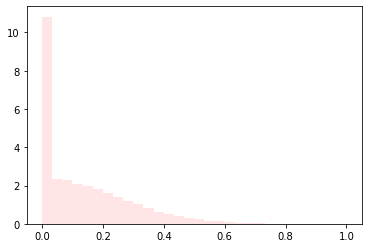

In [472]:
plt.hist(df_after_covid['rev_dti'],30,density=True, color = 'red', alpha=0.1)
plt.show()

In [473]:
frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

In [474]:
# Unsec debt to income

# setting a flag for whether a customer has unsecured debt (outside of revolving debt)

np.random.seed(444)
df_before_covid['unsec_debt_flag'] = np.random.choice(
    a=['Y','N'],
    size=num_rows_before_covid,
    p=[0.22,0.78]
)

np.random.seed(444)
df_after_covid['unsec_debt_flag'] = np.random.choice(
    a=['Y','N'],
    size=num_rows_after_covid,
    p=[0.18,0.82]
)

frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


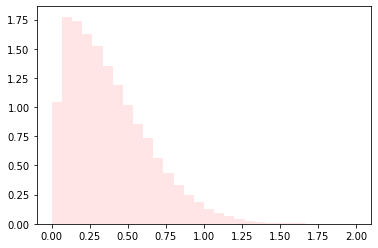

In [475]:
# Unsecured to income continued (before covid)

# generating unsecured debt values for the pre covid period
# unsecured debt before covid tended to be higher and followed a right skewed distribution

numValues = num_rows_before_covid
maxValue = 2
skewness = 50   #Negative values are left skewed, positive values are right skewed.

unsec_dti = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

unsec_dti = unsec_dti - min(unsec_dti)      #Shift the set so the minimum value is equal to zero.
unsec_dti = unsec_dti / max(unsec_dti)      #Standadize all the vlues between 0 and 1. 
unsec_dti = unsec_dti * maxValue         #Multiply the standardized values by the maximum value.

unsec_dti = unsec_dti.tolist() # changing numpy array to list so I can use the pop function later on

#Plot histogram to check skewness
plt.hist(unsec_dti,30,density=True, color = 'red', alpha=0.1)
plt.show()

# function that takes in whether a customer has unsecured debt and applies a unsec_dti value to that customer
def apply_unsec_dti(unsec_debt_flag, unsec_dti_array):    
    if unsec_debt_flag == 'Y':
        i = np.random.randint(len(unsec_dti_array), size=1)[0]
        selected = unsec_dti_array.pop(i)
        return selected
    else:
        return 0

df_before_covid['unsec_dti'] = df_before_covid['unsec_debt_flag'].apply(lambda x: apply_unsec_dti(x,unsec_dti))
df_before_covid['unsec_dti'] = df_before_covid['unsec_dti'] + df_before_covid['rev_dti']

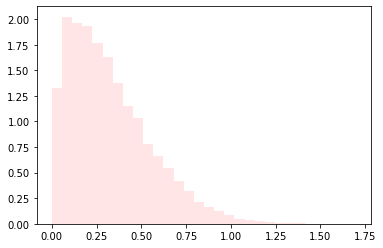

In [476]:
# Unsecured to income continued (after covid)

# unsecured debt after covid tended to be slightly lower but still followed a right skewed distribution

numValues = num_rows_after_covid
maxValue = 1.7
skewness = 50   #Negative values are left skewed, positive values are right skewed.

unsec_dti = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

unsec_dti = unsec_dti - min(unsec_dti)      #Shift the set so the minimum value is equal to zero.
unsec_dti = unsec_dti / max(unsec_dti)      #Standadize all the vlues between 0 and 1. 
unsec_dti = unsec_dti * maxValue         #Multiply the standardized values by the maximum value.

unsec_dti = unsec_dti.tolist()

#Plot histogram to check skewness
plt.hist(unsec_dti,30,density=True, color = 'red', alpha=0.1)
plt.show()

def apply_unsec_dti(unsec_debt_flag, unsec_dti_array):    
    if unsec_debt_flag == 'Y':
        i = np.random.randint(len(unsec_dti_array), size=1)[0]
        selected = unsec_dti_array.pop(i)
        return selected
    else:
        return 0

df_after_covid['unsec_dti'] = df_after_covid['unsec_debt_flag'].apply(lambda x: apply_unsec_dti(x,unsec_dti))
df_after_covid['unsec_dti'] = df_after_covid['unsec_dti'] + df_after_covid['rev_dti']

In [477]:
frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)

In [478]:
# generating actual debt £ values using the income and debt to income fields

# defining a round down function to change the float values for debt into integers
def rounddown(x):
    return int(math.floor(x / 1)) * 1
vrounddown = np.vectorize(rounddown) # vectorizing the function so that it can take in a numpy array and apply to every element

df['rev_debt'] = df.income*df.rev_dti # revolving debt = income * revolving debt to income
df['unsec_debt'] = df.income*df.unsec_dti # unsecured debt = income * unsecured debt to income

df['rev_debt'] = vrounddown(df['rev_debt'])
df['unsec_debt'] = vrounddown(df['unsec_debt'])

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

In [479]:
# banding the values for debt to income
# this will be used to derive an application score

def isbetween(a, x, b):
    return min(a, b) < x < max(a, b)

def get_dti_band(value):
    dti_band = None
    if isbetween(0,value,0.2):
        dti_band='0to0.2'
    if isbetween(0.2,value,0.4):
        dti_band='0.2to0.4'
    if isbetween(0.4,value,0.6):
        dti_band='0.4to0.6'
    if isbetween(0.6,value,0.8):
        dti_band='0.6to0.8'
    if isbetween(0.8,value,1):
        dti_band='0.8to1'
    if isbetween(1,value,1.2):
        dti_band='1to1.2'
    if value > 1.2:
        dti_band='1.2+'
    return dti_band

df['dti_band'] = df['unsec_dti'].apply(lambda x: get_dti_band(x))

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

## Here I am designing a mock scorecard

### A scorecard uses various fields that are indicative of credit-worthiness to determine an application score

A customer is given points for each field, more points indicate a higher level of credit-worthiness, and are
granted for values that historically have indicated low likelihood of default on credit

I have generated data for the following fields:
- years on the job
- years at current address
- years on electoral role
- number of credit searches in the last 6 months
- unsecured debt

I define a set of rules that grant points based on these values. The final application score is based on these points.

My scorecard is very basic. Real scorecards include many more fields and are much more comprehensive in assessing credit score.
My scorecard is however a good representation of how a real scorecard works. 

Many of the variables that I have included do not show much variation in the pre vs post covid period. This means that the scores that my scorecard generates do not show much variation before covid vs after.
I have included a pre_covid flag, which will adjust the points for a given application. The result of this is to ensure that the average application score pre covid is lower than the average application score post covid.

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


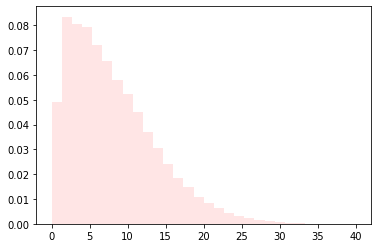

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


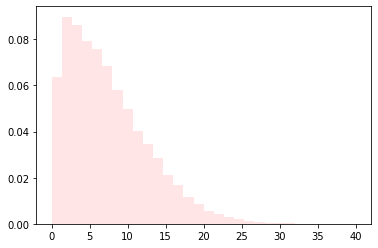

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [482]:
# Years on job

# before covid

np.random.seed(444)
df_before_covid['employed_flag'] = np.random.choice(
    a=['Y','N'],
    size=num_rows_before_covid,
    p=[0.95,0.05] # 95% of applicants are employed
)

# generate a years_on_job values only for the applicants that are employed
# years on job tends to max out at 40 and follows a right skewed distribution
numValues = df_before_covid['employed_flag'].value_counts()[0]
maxValue = 40
skewness = 50   #Negative values are left skewed, positive values are right skewed.

years_on_job = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

years_on_job = years_on_job - min(years_on_job)      #Shift the set so the minimum value is equal to zero.
years_on_job = years_on_job / max(years_on_job)      #Standadize all the vlues between 0 and 1. 
years_on_job = years_on_job * maxValue         #Multiply the standardized values by the maximum value.

years_on_job = years_on_job.tolist()

#Plot histogram to check skewness
plt.hist(years_on_job,30,density=True, color = 'red', alpha=0.1)
plt.show()

def apply_years_on_job(employed_flag, years_on_job_array):    
    if employed_flag == 'Y':
        i = np.random.randint(len(years_on_job_array), size=1)[0]
        selected = years_on_job.pop(i)
        return selected
    else:
        return 0

df_before_covid['years_on_job'] = df_before_covid['employed_flag'].apply(lambda x: apply_years_on_job(x,years_on_job))

# after covid

np.random.seed(444)
df_after_covid['employed_flag'] = np.random.choice(
    a=['Y','N'],
    size=num_rows_after_covid,
    p=[0.9,0.1]
)

numValues = df_after_covid['employed_flag'].value_counts()[0]
maxValue = 40
skewness = 50   #Negative values are left skewed, positive values are right skewed.

years_on_job = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

years_on_job = years_on_job - min(years_on_job)      #Shift the set so the minimum value is equal to zero.
years_on_job = years_on_job / max(years_on_job)      #Standadize all the vlues between 0 and 1. 
years_on_job = years_on_job * maxValue         #Multiply the standardized values by the maximum value.

years_on_job = years_on_job.tolist()

#Plot histogram to check skewness
plt.hist(years_on_job,30,density=True, color = 'red', alpha=0.1)
plt.show()

def apply_years_on_job(employed_flag, years_on_job_array):    
    if employed_flag == 'Y':
        i = np.random.randint(len(years_on_job_array), size=1)[0]
        selected = years_on_job.pop(i)
        return selected
    else:
        return 0

df_after_covid['years_on_job'] = df_after_covid['employed_flag'].apply(lambda x: apply_years_on_job(x,years_on_job))

frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)

# round down to get an int instead of a float
def rounddown(x):
    return int(math.floor(x / 1)) * 1
vrounddown = np.vectorize(rounddown)

df['years_on_job'] = vrounddown(df['years_on_job'])

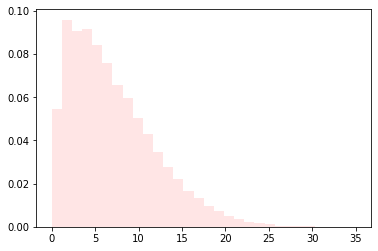

In [483]:
# Years on electoral role

np.random.seed(444)
df['electoral_role_flag'] = np.random.choice(
    a=['Y','N'],
    size=num_rows,
    p=[0.7,0.3]
)

numValues = df['electoral_role_flag'].value_counts()[0]
maxValue = 35
skewness = 50   #Negative values are left skewed, positive values are right skewed.

years_on_electoral_role = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

years_on_electoral_role = years_on_electoral_role - min(years_on_electoral_role)      #Shift the set so the minimum value is equal to zero.
years_on_electoral_role = years_on_electoral_role / max(years_on_electoral_role)      #Standadize all the vlues between 0 and 1. 
years_on_electoral_role = years_on_electoral_role * maxValue         #Multiply the standardized values by the maximum value.

years_on_electoral_role = years_on_electoral_role.tolist()

#Plot histogram to check skewness
plt.hist(years_on_electoral_role,30,density=True, color = 'red', alpha=0.1)
plt.show()

def apply_years_on_electoral_role(electoral_role_flag, years_on_electoral_role_array):    
    if electoral_role_flag == 'Y':
        i = np.random.randint(len(years_on_electoral_role_array), size=1)[0]
        selected = years_on_electoral_role.pop(i)
        return selected
    else:
        return 0

df['years_on_electoral_role'] = df['electoral_role_flag'].apply(lambda x: apply_years_on_electoral_role(x,years_on_electoral_role))

def rounddown(x):
    return int(math.floor(x / 1)) * 1
vrounddown = np.vectorize(rounddown)

df['years_on_electoral_role'] = vrounddown(df['years_on_electoral_role'])

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

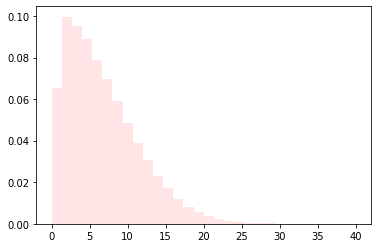

In [484]:
# Years at address

numValues = num_rows
maxValue = 40
skewness = 50   #Negative values are left skewed, positive values are right skewed.

years_at_address = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

years_at_address = years_at_address - min(years_at_address)      #Shift the set so the minimum value is equal to zero.
years_at_address = years_at_address / max(years_at_address)      #Standadize all the vlues between 0 and 1. 
years_at_address = years_at_address * maxValue         #Multiply the standardized values by the maximum value.

#Plot histogram to check skewness
plt.hist(years_at_address,30,density=True, color = 'red', alpha=0.1)
plt.show()

df['years_at_address'] = years_at_address

def rounddown(x):
    return int(math.floor(x / 1)) * 1
vrounddown = np.vectorize(rounddown)

df['years_at_address'] = vrounddown(df['years_at_address'])

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

In [485]:
# Searches in the last 6 months

np.random.seed(444)
df['searches_l6m'] = np.random.choice(
    a=[0,1,2,3,4,5],
    size=num_rows,
    p=[0.32,0.4,0.18,0.055,0.035,0.01]
)

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

In [486]:
# setting a flag for before or after covid as a brute force way to adjust score so that final distribution is similar to reality

df_before_covid['before_covid'] = True
df_after_covid['before_covid'] = False

frames = [df_before_covid,df_after_covid]
df = pd.concat(frames, ignore_index=True)

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [487]:
# function for calculating points. These points are they used to calculate application score
def calc_points(dti_band, years_on_job, years_at_address, years_on_electoral_role, searches_l6m, before_covid):
    
    """
    max points for:
    dti - 40
    years on job - 45
    years at address - 30
    years on electoral role - 25
    searches - 30
    """
    
    points = 0
      
    if dti_band == '0to0.2' or dti_band == None:       
        points += 40
    if dti_band == '0.2to0.4':   
        points += 35
    if dti_band == '0.4to0.6': 
        points += 28
    if dti_band == '0.6to0.8':       
        points += 20
    if dti_band == '0.8to1':   
        points += 10
    if dti_band == '1to1.2':  
        points += 5
    if dti_band == '1.2+':  
        points += 0
        
    if years_on_job == 0 or years_on_job == None:
        points += 0
    if years_on_job > 0 and years_on_job <= 2:
        points += 15
    if years_on_job > 2 and years_on_job <= 5:
        points += 25
    if years_on_job > 5 and years_on_job <= 8:
        points += 35
    if years_on_job > 8:
        points += 45
        
    if years_at_address == 0 or years_at_address == None:
        points += 0
    if years_at_address > 0 and years_at_address <= 3:
        points += 10
    if years_at_address > 3 and years_at_address <= 6:
        points += 15
    if years_at_address > 6 and years_at_address <= 10:
        points += 25
    if years_at_address > 10:
        points += 30
        
    if years_on_electoral_role == 0 or years_on_electoral_role == None:
        points += 0
    if years_on_electoral_role > 0 and years_on_electoral_role <= 2:
        points += 5
    if years_on_electoral_role > 2 and years_on_electoral_role <= 4:
        points += 12
    if years_on_electoral_role > 4 and years_on_electoral_role <= 6:
        points += 20
    if years_on_electoral_role > 6 and years_on_electoral_role <= 8:
        points += 25
    if years_on_electoral_role > 8:
        points += 30
        
    if searches_l6m == 0 or searches_l6m == None:
        points += 30
    if searches_l6m == 1:
        points += 24
    if searches_l6m == 2:
        points += 18
    if searches_l6m == 3:
        points += 12
    if searches_l6m == 4:
        points += 5
    if searches_l6m == 5:
        points += 0
        
    # brute force adjustment to make final distribution look like the real distribution of scores before vs after covid
    if before_covid == True:
        points -= 20
    if before_covid == False:
        points += 20
        
    return points
        
df['scorecard_points'] = df.apply(lambda x: calc_points(x['dti_band'], x['years_on_job'], x['years_at_address'], x['years_on_electoral_role'], x['searches_l6m'], x['before_covid']),axis=1)

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


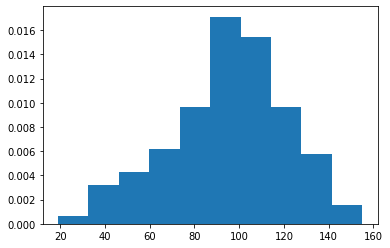

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


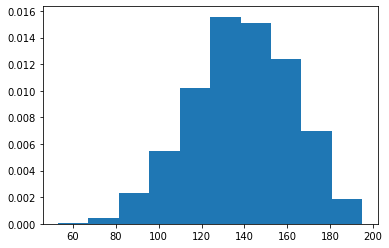

In [488]:
fig, ax = plt.subplots()
ax.hist(df_before_covid['scorecard_points'], normed=True)
plt.show()

fig, ax = plt.subplots()
ax.hist(df_after_covid['scorecard_points'], normed=True)
plt.show()

In [489]:
# Score

# in a full scorecard the points total would be the application score
# because I haven't built a full scorecard I simply add 520 to account for the other fields not included
def calc_score(scorecard_points):
    score = scorecard_points + 520 
    return score

df['score'] = df['scorecard_points'].apply(lambda x: calc_score(x))

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


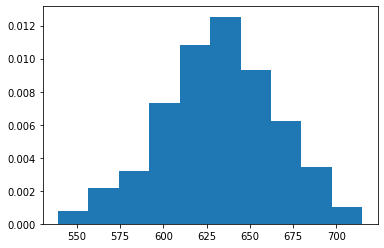

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


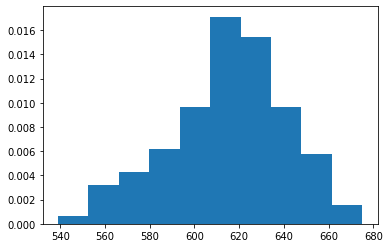

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


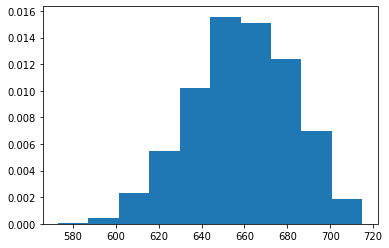

In [490]:
fig, ax = plt.subplots()
ax.hist(df['score'], normed=True)
plt.show()

fig, ax = plt.subplots()
ax.hist(df_before_covid['score'], normed=True)
plt.show()

fig, ax = plt.subplots()
ax.hist(df_after_covid['score'], normed=True)
plt.show()

In [493]:
# create score bands

def isbetween(a, x, b):
    return min(a, b) < x < max(a, b)

def get_score_band(value):
    score_band = None
    if isbetween(0,value,501):
        score_band='<=500'
    if isbetween(500,value,531):
        score_band='501-530'
    if isbetween(530,value,561):
        score_band='531-560'
    if isbetween(560,value,591):
        score_band='561-590'
    if isbetween(590,value,621):
        score_band='591-620'
    if isbetween(620,value,641):
        score_band='621-640'
    if isbetween(640,value,661):
        score_band='641-660'
    if isbetween(660,value,681):
        score_band='661-680'
    if isbetween(680,value,701):
        score_band='681-700'
    if value > 700:
        score_band='>700'

    return score_band

df['score_band'] = df['score'].apply(lambda x: get_score_band(x))

In [494]:
# Initial accept

# calculate number of applications that are accepted, referred or declined

def calc_accept(score):
    
    if score < 591: 
        initial_accept = np.random.choice(
            a=['accept', 'refer', 'decline'],
            size=1,
            p=[0.055,0.065,0.88]
        )
        return initial_accept[0]
    if score < 621 and score > 590: 
        initial_accept = np.random.choice(
            a=['accept', 'refer', 'decline'],
            size=1,
            p=[0.25,0.2,0.55]
        )
        return initial_accept[0]
    if score < 641 and score > 620: 
        initial_accept = np.random.choice(
            a=['accept', 'refer', 'decline'],
            size=1,
            p=[0.48,0.2,0.32]
        )
        return initial_accept[0]
    if score < 661 and score > 640: 
        initial_accept = np.random.choice(
            a=['accept', 'refer', 'decline'],
            size=1,
            p=[0.57,0.18,0.25]
        )
        return initial_accept[0]
    if score < 681 and score > 660: 
        initial_accept = np.random.choice(
            a=['accept', 'refer', 'decline'],
            size=1,
            p=[0.71,0.15,0.14]
        )
        return initial_accept[0]
    if score < 701 and score > 680: 
        initial_accept = np.random.choice(
            a=['accept', 'refer', 'decline'],
            size=1,
            p=[0.79,0.15,0.06]
        )
        return initial_accept[0]
    if score > 700: 
        initial_accept = np.random.choice(
            a=['accept', 'refer', 'decline'],
            size=1,
            p=[0.82,0.14,0.04]
        )
        return initial_accept[0]
        
df['initial_accept'] = df['score'].apply(lambda x: calc_accept(x))

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

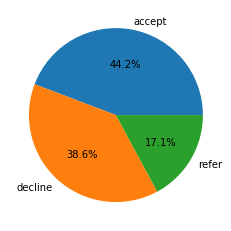

In [495]:
fig, ax = plt.subplots(1, 1)
labels = 'accept', 'decline', 'refer'
ax.pie(df['initial_accept'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.show()

In [496]:
# of the applications that were referred, calc final accept based on probabilities of applications eventually getting accepted or declined
# if initial_accept was accept or decline, final accept is the same

def calc_final_accept(init_accept):
    if init_accept == 'accept':
        return 'accept'
    if init_accept == 'decline':
        return 'decline'
    if init_accept == 'refer':
        final_accept = np.random.choice(
            a=['accept', 'decline'],
            size=1,
            p=[0.08,0.92]
        )
        return final_accept[0]
        
df['final_accept'] = df['initial_accept'].apply(lambda x: calc_final_accept(x))

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

In [497]:
# calculate where a customer who has had their application accepted actually takes up the offer

def calc_takeup(final_accept):
    if final_accept == 'accept':
        takeup = np.random.choice(
            a=['Y', 'N'],
            size=1,
            p=[0.88,0.12] # 88% take up the card
        )
        return takeup[0]
    if final_accept == 'decline':
        return None
    
df['takeup'] = df['final_accept'].apply(lambda x: calc_takeup(x))
df['booked'] = df['takeup'] # we book all cards that are taken up

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


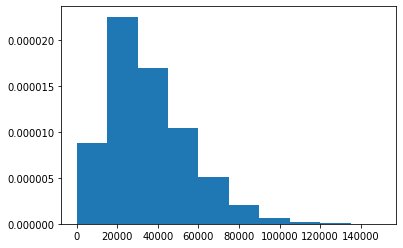

In [498]:
fig, ax = plt.subplots()
ax.hist(df['income'], normed=True)
plt.show()

In [499]:
# calculate offered credit limit

def rounddown(x):
    return int(math.floor(x / 500.0)) * 500 # round down to the nearest 500

# offered credit limit is normally based on a customer's income
def calc_limit(income, booked):
    if booked == 'Y':
        return rounddown(income/10)
    else:
        return None
    
df['offered_limit'] = df.apply(lambda x: calc_limit(x['income'], x['booked']),axis=1)

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

In [500]:
# some customers don't need all of the credit we offer so they take a final limit that is lower than the offered limit

def final_limit_same(offered_limit):
    if offered_limit >= 0:
        final_limit_same = np.random.choice(
            a=['Y', 'N'],
            size=1,
            p=[0.98,0.02]
        )
        return final_limit_same[0]
    else:
        return None
    
df['final_limit_same'] = df['offered_limit'].apply(lambda x: final_limit_same(x))

def calc_final_limit(offered_limit, final_limit_same):
    if final_limit_same == 'N':
        possible_values = [0.95,0.9,0.85,0.8]  
        i = np.random.randint(4, size=1)[0]
        return offered_limit*possible_values[i]
    else:
        return offered_limit
    
df['final_limit'] = df.apply(lambda x: calc_final_limit(x['offered_limit'], x['final_limit_same']),axis=1)

df_before_covid = df[df['date']<=datetime.date(year=2020,month=3,day=23)]
df_after_covid = df[df['date']>datetime.date(year=2020,month=3,day=23)]

### Putting it all together to output final dataframe

In [501]:
df

,app_ref,date,channel,product_type,income,external_card,rev_dti,unsec_debt_flag,unsec_dti,rev_debt,...,scorecard_points,score,score_band,initial_accept,final_accept,takeup,booked,offered_limit,final_limit_same,final_limit
0,1,2020-01-16,branch,RE,21360,N,0.000000,N,0.000000,0,...,78,598,591-620,accept,accept,Y,Y,2000.0,Y,2000.0
1,2,2019-12-22,branch,RE,62511,N,0.000000,N,0.000000,0,...,78,598,591-620,decline,decline,None,None,NaN,None,NaN
2,3,2019-06-01,internet_non_agg,BT,22774,Y,0.614851,N,0.614851,14002,...,109,629,621-640,accept,accept,Y,Y,2000.0,Y,2000.0
3,4,2019-06-20,internet_non_agg,BT,59439,Y,0.019681,N,0.019681,1169,...,99,619,591-620,decline,decline,None,None,NaN,None,NaN
4,5,2019-10-04,internet_aggregator,MA,22035,Y,0.115475,Y,0.314657,2544,...,127,647,641-660,accept,accept,Y,Y,2000.0,Y,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,2021-01-29,internet_aggregator,MA,31503,Y,0.090216,N,0.090216,2842,...,145,665,661-680,accept,accept,Y,Y,3000.0,Y,3000.0
99996,99997,2021-01-01,internet_non_agg,BT,77086,N,0.000000,N,0.000000,0,...,154,674,661-680,accept,accept,Y,Y,7500.0,Y,7500.0
99997,99998,2021-11-04,internet_aggregator,MA,26018,Y,0.037523,N,0.037523,976,...,125,645,641-660,accept,accept,Y,Y,2500.0,Y,2500.0
99998,99999,2021-02-19,internet_non_agg,RE,48430,N,0.000000,N,0.000000,0,...,128,648,641-660,refer,decline,None,None,NaN,None,NaN


In [502]:
# drop rows to produce final output df

df.drop(['rev_dti', 'unsec_debt_flag', 'unsec_dti', 'dti_band', 'employed_flag', 'years_on_job', 'years_at_address',
         'electoral_role_flag', 'years_on_electoral_role', 'searches_l6m', 'before_covid', 'scorecard_points', 
         'score_band', 'final_limit_same',], axis=1, inplace=True)
df

,app_ref,date,channel,product_type,income,external_card,rev_debt,unsec_debt,score,initial_accept,final_accept,takeup,booked,offered_limit,final_limit
0,1,2020-01-16,branch,RE,21360,N,0,0,598,accept,accept,Y,Y,2000.0,2000.0
1,2,2019-12-22,branch,RE,62511,N,0,0,598,decline,decline,None,None,NaN,NaN
2,3,2019-06-01,internet_non_agg,BT,22774,Y,14002,14002,629,accept,accept,Y,Y,2000.0,2000.0
3,4,2019-06-20,internet_non_agg,BT,59439,Y,1169,1169,619,decline,decline,None,None,NaN,NaN
4,5,2019-10-04,internet_aggregator,MA,22035,Y,2544,6933,647,accept,accept,Y,Y,2000.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,2021-01-29,internet_aggregator,MA,31503,Y,2842,2842,665,accept,accept,Y,Y,3000.0,3000.0
99996,99997,2021-01-01,internet_non_agg,BT,77086,N,0,0,674,accept,accept,Y,Y,7500.0,7500.0
99997,99998,2021-11-04,internet_aggregator,MA,26018,Y,976,976,645,accept,accept,Y,Y,2500.0,2500.0
99998,99999,2021-02-19,internet_non_agg,RE,48430,N,0,0,648,refer,decline,None,None,NaN,NaN


### Export as a CSV file to read into Power BI

In [503]:
# export as CSV file
df.to_csv('app_data.csv')